In [27]:
!pip install kagglehub tensorflow matplotlib


In [28]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
import kagglehub


In [29]:
# Download dataset from Kaggle Hub
path = kagglehub.dataset_download("mbkinaci/fruit-images-for-object-detection")
print("Downloaded to:", path)


Using Colab cache for faster access to the 'fruit-images-for-object-detection' dataset.
Downloaded to: /kaggle/input/fruit-images-for-object-detection


In [30]:
dataset_path = Path(path)

train_dir = dataset_path / "train_zip" / "train"
test_dir  = dataset_path / "test_zip" / "test"

print("Train dir:", train_dir)
print("Test dir :", test_dir)
print("Train images:", len(list(train_dir.glob("*.jpg"))))
print("Test images :", len(list(test_dir.glob("*.jpg"))))


Train dir: /kaggle/input/fruit-images-for-object-detection/train_zip/train
Test dir : /kaggle/input/fruit-images-for-object-detection/test_zip/test
Train images: 240
Test images : 60


In [31]:
CLASS_NAMES = ["apple", "banana", "orange"]
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    labels = []
    for obj in root.findall("object"):
        cls = obj.find("name").text.lower()
        labels.append(CLASS_TO_IDX[cls])
    return labels


In [33]:
def _load_example(img_path, xml_path):
    # Convert paths from tensor → python strings
    img_path = img_path.numpy().decode()
    xml_path = xml_path.numpy().decode()

    # Load & preprocess image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img / 255.0

    # Get label (take first object label)
    labels = parse_annotation(xml_path)
    label = np.array(labels[0], dtype=np.int32)

    return img, label


def make_classification_dataset(folder, batch=8, shuffle=True):
    images = [str(p) for p in sorted(folder.glob("*.jpg"))]
    annots = [str(p) for p in sorted(folder.glob("*.xml"))]

    ds = tf.data.Dataset.from_tensor_slices((images, annots))

    if shuffle:
        ds = ds.shuffle(len(images))

    def wrapper(img, xml):
        img, label = tf.py_function(_load_example, [img, xml], [tf.float32, tf.int32])
        img.set_shape((224,224,3))
        label.set_shape(())
        return img, label

    ds = ds.map(wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = make_classification_dataset(train_dir, batch=16)
test_ds  = make_classification_dataset(test_dir, shuffle=False)


In [34]:
def simple_cnn():
    model = keras.Sequential([
        keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224,224,3)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128, 3, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [35]:
def transfer_model():
    base = keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base.trainable = False
    x = keras.layers.GlobalAveragePooling2D()(base.output)
    x = keras.layers.Dropout(0.3)(x)
    out = keras.layers.Dense(3, activation="softmax")(x)
    model = keras.Model(base.input, out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [36]:
def transfer_model():
    base = keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base.trainable = False
    x = keras.layers.GlobalAveragePooling2D()(base.output)
    x = keras.layers.Dropout(0.3)(x)
    out = keras.layers.Dense(3, activation="softmax")(x)
    model = keras.Model(base.input, out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [37]:
cnn = simple_cnn()
history_cnn = cnn.fit(train_ds, epochs=6, validation_data=test_ds)


Epoch 1/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4162 - loss: 2.4857 - val_accuracy: 0.6167 - val_loss: 0.6986
Epoch 2/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6857 - loss: 0.6445 - val_accuracy: 0.7833 - val_loss: 0.7120
Epoch 3/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8511 - loss: 0.3531 - val_accuracy: 0.8667 - val_loss: 0.7333
Epoch 4/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8690 - loss: 0.3284 - val_accuracy: 0.8833 - val_loss: 0.6571
Epoch 5/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9343 - loss: 0.1990 - val_accuracy: 0.8667 - val_loss: 0.6460
Epoch 6/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9618 - loss: 0.1181 - val_accuracy: 0.8667 - val_loss: 0.6066


In [38]:
tmodel = transfer_model()
history_tl = tmodel.fit(train_ds, epochs=5, validation_data=test_ds)


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 970ms/step - accuracy: 0.3704 - loss: 1.2962 - val_accuracy: 0.9000 - val_loss: 0.4105
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 895ms/step - accuracy: 0.7976 - loss: 0.4625 - val_accuracy: 0.9500 - val_loss: 0.2029
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 884ms/step - accuracy: 0.9424 - loss: 0.2147 - val_accuracy: 0.9500 - val_loss: 0.1602
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 870ms/step - accuracy: 0.9630 - loss: 0.1543 - val_accuracy: 0.9500 - val_loss: 0.1435
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9701 - loss: 0.1281 - val_accuracy: 0.9500 - val_loss: 0.1389


In [39]:
tmodel.trainable = True
for layer in tmodel.layers[:100]:
    layer.trainable = False

history_ft = tmodel.fit(train_ds, epochs=5, validation_data=test_ds)


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9607 - loss: 0.1077 - val_accuracy: 0.9500 - val_loss: 0.1385
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 885ms/step - accuracy: 0.9952 - loss: 0.0644 - val_accuracy: 0.9667 - val_loss: 0.1336
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 899ms/step - accuracy: 0.9737 - loss: 0.0903 - val_accuracy: 0.9500 - val_loss: 0.1423
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 998ms/step - accuracy: 0.9953 - loss: 0.0504 - val_accuracy: 0.9667 - val_loss: 0.1351
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 886ms/step - accuracy: 0.9934 - loss: 0.0584 - val_accuracy: 0.9667 - val_loss: 0.1334


In [40]:
print("Simple CNN:")
cnn.evaluate(test_ds)

print("Transfer + Fine-tuning:")
tmodel.evaluate(test_ds)

tmodel.save("best_fruit_classifier.h5")
print("✅ Saved model as best_fruit_classifier.h5")


Simple CNN:
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.9087 - loss: 0.4071
Transfer + Fine-tuning:
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.9812 - loss: 0.0942


✅ Saved model as best_fruit_classifier.h5


In [44]:
model = keras.models.load_model("best_fruit_classifier.h5")


Testing: banana_77.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: banana (99.84%)


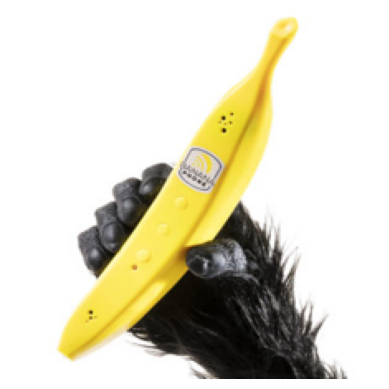

In [45]:
import random
from PIL import Image

def test_random_image():
    sample = random.choice(list(test_dir.glob("*.jpg")))
    print("Testing:", sample.name)

    img = Image.open(sample).resize((224,224))
    plt.imshow(img)
    plt.axis('off')

    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    cls = CLASS_NAMES[np.argmax(pred)]
    conf = np.max(pred)

    print(f"Prediction: {cls} ({conf*100:.2f}%)")

test_random_image()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


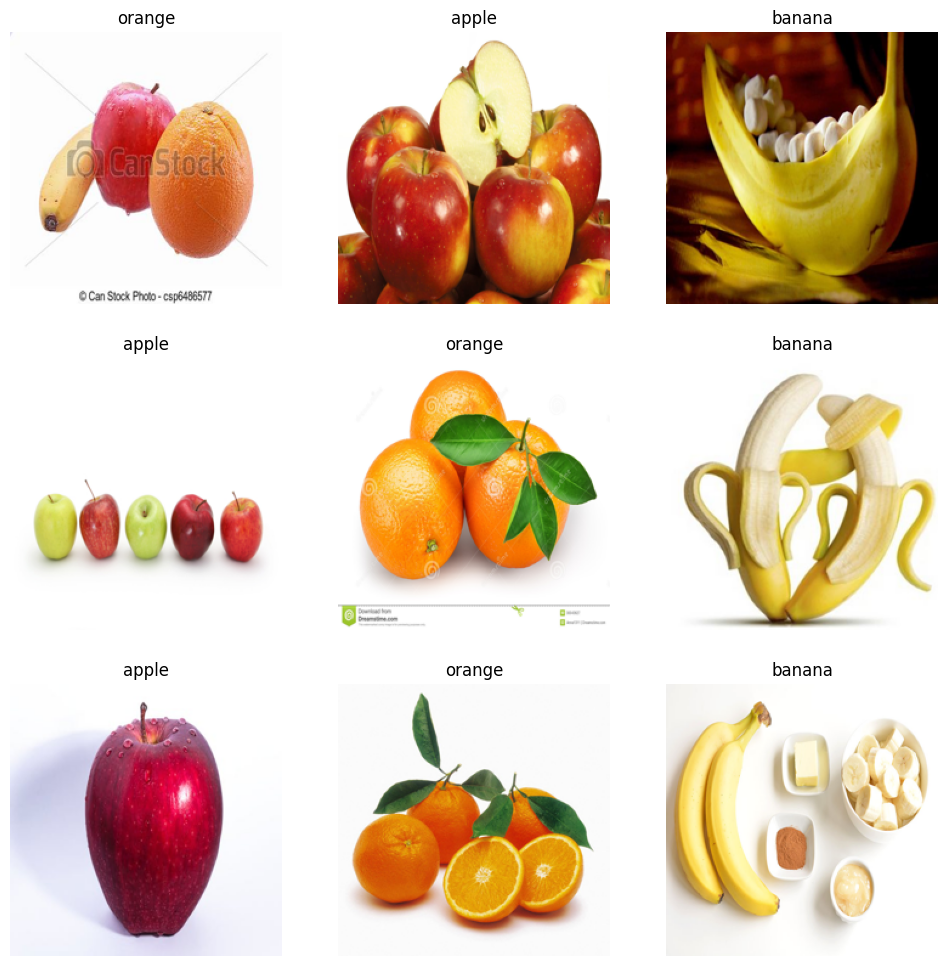

In [48]:
def test_grid(num=9):
    samples = random.sample(list(test_dir.glob("*.jpg")), num)
    plt.figure(figsize=(12,12))

    for i, img_path in enumerate(samples):
        img = Image.open(img_path).resize((224,224))
        arr = np.array(img) / 255.0
        arr = np.expand_dims(arr, axis=0)

        pred = model.predict(arr)
        cls = CLASS_NAMES[np.argmax(pred)]

        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')

    plt.show()

test_grid()


In [49]:
loss, acc = model.evaluate(test_ds)
print(f"\n✅ Final Test Accuracy: {acc*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.9812 - loss: 0.0942

✅ Final Test Accuracy: 96.67%


In [50]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for x, y in test_ds:
    preds = model.predict(x)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step

Classification Report:

              precision    recall  f1-score   support

       apple       1.00      0.95      0.97        20
      banana       0.95      0.95      0.95        19
      orange       0.95      1.00      0.98        21

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

